In [1]:
import pandas as pd
from scipy.stats import fisher_exact

# Load the data
case_data = pd.read_csv('PC_case.csv')
control_data = pd.read_csv('PC_control.csv')
gene_list = pd.read_csv('geneList.csv')

# Display data structure for understanding
case_data.head(), control_data.head(), gene_list.head()

(   14   38304539  107289436  dup  SP114974
 0  13  106542688  115109852  dup  SP114986
 1   8   90067523   90940205  dup  SP114980
 2  13   82892302   94651715  dup  SP114978
 3  10  116642982  116959246  del  SP114982
 4   1  157319909  157774897  dup  SP114974,
    1   48044793   48045010  del  NA19755
 0  1  219923308  219923626  del  NA12043
 1  1  183118733  183119274  del  NA20341
 2  1   25900344   25908041  del  NA18597
 3  1    9822405    9825678  del  HG00419
 4  1   41746258   41749818  del  HG00276,
    ENSG00000198695  0  chr0  14149  14671
 0  ENSG00000198712  0  chr0   7643   8269
 1  ENSG00000198727  0  chr0  14750  15887
 2  ENSG00000198763  0  chr0   4721   5511
 3  ENSG00000198786  0  chr0    319  16571
 4  ENSG00000198804  0  chr0   3440   7492)

In [2]:
# Rename columns for clarity
case_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
control_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
gene_list.columns = ['Gene_ID', 'Unused', 'Chromosome', 'Gene_Start', 'Gene_End']

# Drop unused column in gene_list
gene_list = gene_list.drop(columns=['Unused'])

# Display updated structures for validation
case_data.head(), control_data.head(), gene_list.head()

(  Chromosome      Start        End Type Patient_ID
 0         13  106542688  115109852  dup   SP114986
 1          8   90067523   90940205  dup   SP114980
 2         13   82892302   94651715  dup   SP114978
 3         10  116642982  116959246  del   SP114982
 4          1  157319909  157774897  dup   SP114974,
   Chromosome      Start        End Type Patient_ID
 0          1  219923308  219923626  del    NA12043
 1          1  183118733  183119274  del    NA20341
 2          1   25900344   25908041  del    NA18597
 3          1    9822405    9825678  del    HG00419
 4          1   41746258   41749818  del    HG00276,
            Gene_ID Chromosome  Gene_Start  Gene_End
 0  ENSG00000198712       chr0        7643      8269
 1  ENSG00000198727       chr0       14750     15887
 2  ENSG00000198763       chr0        4721      5511
 3  ENSG00000198786       chr0         319     16571
 4  ENSG00000198804       chr0        3440      7492)

In [4]:
# Group data by Chromosome and Region for case and control
case_regions = case_data.groupby(['Chromosome', 'Start', 'End', 'Type']).size().reset_index(name='Case_Count')
control_regions = control_data.groupby(['Chromosome', 'Start', 'End', 'Type']).size().reset_index(name='Control_Count')

# Merge the case and control data on Chromosome, Start, End, and Type
merged_regions = pd.merge(case_regions, control_regions,
                          on=['Chromosome', 'Start', 'End', 'Type'],
                          how='outer').fillna(0)

# Statistical test to identify significant regions
def fisher_test(row):
    # Contingency table: [[case presence, control presence], [case absence, control absence]]
    case_presence = row['Case_Count']
    control_presence = row['Control_Count']
    total_case = case_data['Patient_ID'].nunique()
    total_control = control_data['Patient_ID'].nunique()
    case_absence = total_case - case_presence
    control_absence = total_control - control_presence
    contingency_table = [[case_presence, control_presence], [case_absence, control_absence]]
    _, p_value = fisher_exact(contingency_table, alternative='greater')
    return p_value

# Apply Fisher's exact test to each row
merged_regions['P_Value'] = merged_regions.apply(fisher_test, axis=1)

# Filter significant regions (p-value < 0.05)
significant_regions = merged_regions[merged_regions['P_Value'] < 0.05]

# tools.display_dataframe_to_user(name="Significant Chromosomal Regions", dataframe=significant_regions)

In [ ]:
# import ace_tools as tools

# # Re-display significant regions after optimization
# tools.display_dataframe_to_user(name="Optimized Significant Chromosomal Regions", dataframe=significant_regions)

In [5]:
# Map significant regions to genes
def map_to_genes(region, genes):
    region_chrom = str(region['Chromosome'])
    region_start = region['Start']
    region_end = region['End']
    overlapping_genes = genes[
        (genes['Chromosome'] == f'chr{region_chrom}') &
        (genes['Gene_End'] >= region_start) &
        (genes['Gene_Start'] <= region_end)
    ]
    return ";".join(overlapping_genes['Gene_ID'])

# Apply mapping to each significant region
significant_regions['Associated_Genes'] = significant_regions.apply(
    lambda row: map_to_genes(row, gene_list), axis=1
)

# tools.display_dataframe_to_user(name="Significant Regions with Associated Genes", dataframe=significant_regions)


<ipython-input-5-b1dc15c6e287>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_regions['Associated_Genes'] = significant_regions.apply(


In [6]:
import pandas as pd
from scipy.stats import fisher_exact

# Load the data
case_data = pd.read_csv('PC_case.csv')
control_data = pd.read_csv('PC_control.csv')
gene_list = pd.read_csv('geneList.csv')

# Rename columns for clarity
case_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
control_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
gene_list.columns = ['Gene_ID', 'Unused', 'Chromosome', 'Gene_Start', 'Gene_End']

# Drop unused column in gene_list
gene_list = gene_list.drop(columns=['Unused'])

# Group case and control data by chromosomal regions
case_regions = case_data.groupby(['Chromosome', 'Start', 'End', 'Type']).size().reset_index(name='Case_Count')
control_regions = control_data.groupby(['Chromosome', 'Start', 'End', 'Type']).size().reset_index(name='Control_Count')

# Merge case and control regions
merged_regions = pd.merge(case_regions, control_regions, on=['Chromosome', 'Start', 'End', 'Type'], how='outer').fillna(0)
merged_regions['Case_Count'] = merged_regions['Case_Count'].astype(int)
merged_regions['Control_Count'] = merged_regions['Control_Count'].astype(int)

# Calculate total case and control patient counts
total_case_patients = case_data['Patient_ID'].nunique()
total_control_patients = control_data['Patient_ID'].nunique()

# Perform Fisher's exact test
def fast_fisher(row, total_case, total_control):
    case_presence = row['Case_Count']
    control_presence = row['Control_Count']
    case_absence = total_case - case_presence
    control_absence = total_control - control_presence
    contingency = [[case_presence, control_presence], [case_absence, control_absence]]
    _, p_val = fisher_exact(contingency, alternative='greater')
    return p_val

merged_regions['P_Value'] = merged_regions.apply(
    lambda row: fast_fisher(row, total_case_patients, total_control_patients), axis=1
)

# Filter significant regions
significant_regions = merged_regions[merged_regions['P_Value'] < 0.05]

# Map significant regions to genes
def map_to_genes(region, genes):
    region_chrom = str(region['Chromosome'])
    region_start = region['Start']
    region_end = region['End']
    overlapping_genes = genes[
        (genes['Chromosome'] == f'chr{region_chrom}') &
        (genes['Gene_End'] >= region_start) &
        (genes['Gene_Start'] <= region_end)
    ]
    return ";".join(overlapping_genes['Gene_ID'])

significant_regions['Associated_Genes'] = significant_regions.apply(
    lambda row: map_to_genes(row, gene_list), axis=1
)

# Save results to a CSV file
significant_regions.to_csv('Significant_Regions_with_Genes.csv', index=False)

print("Significant regions with associated genes saved to 'Significant_Regions_with_Genes.csv'.")


Significant regions with associated genes saved to 'Significant_Regions_with_Genes.csv'.


<ipython-input-6-f1ebf3bc132d>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_regions['Associated_Genes'] = significant_regions.apply(


<ipython-input-8-46ef3d0b5f17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_regions['Chromosome'] = significant_regions['Chromosome'].astype(str)


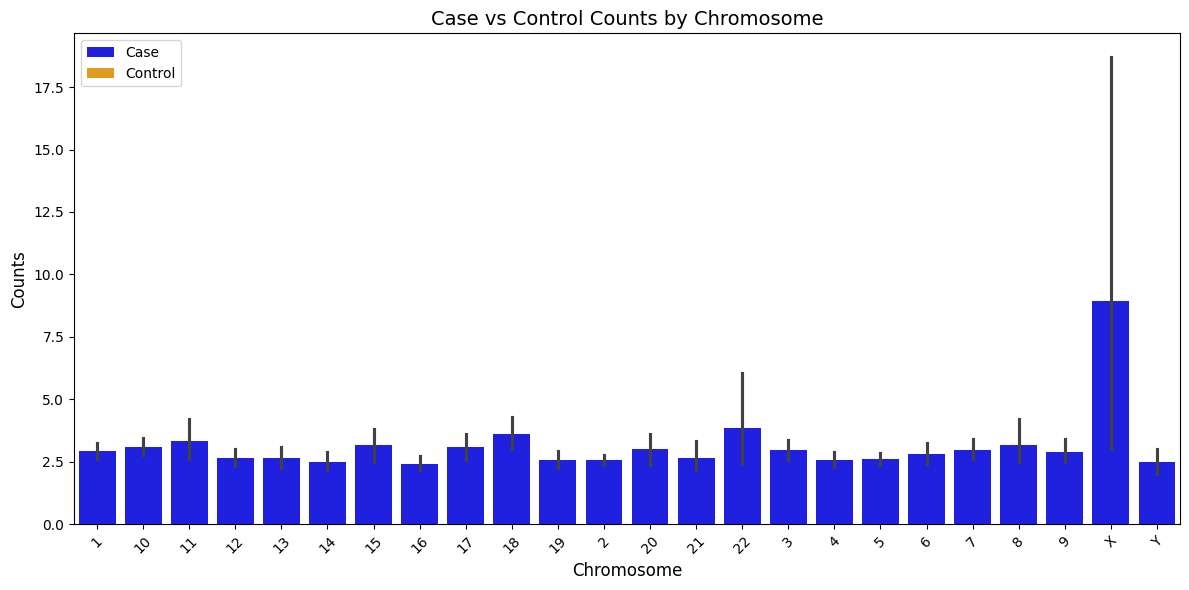

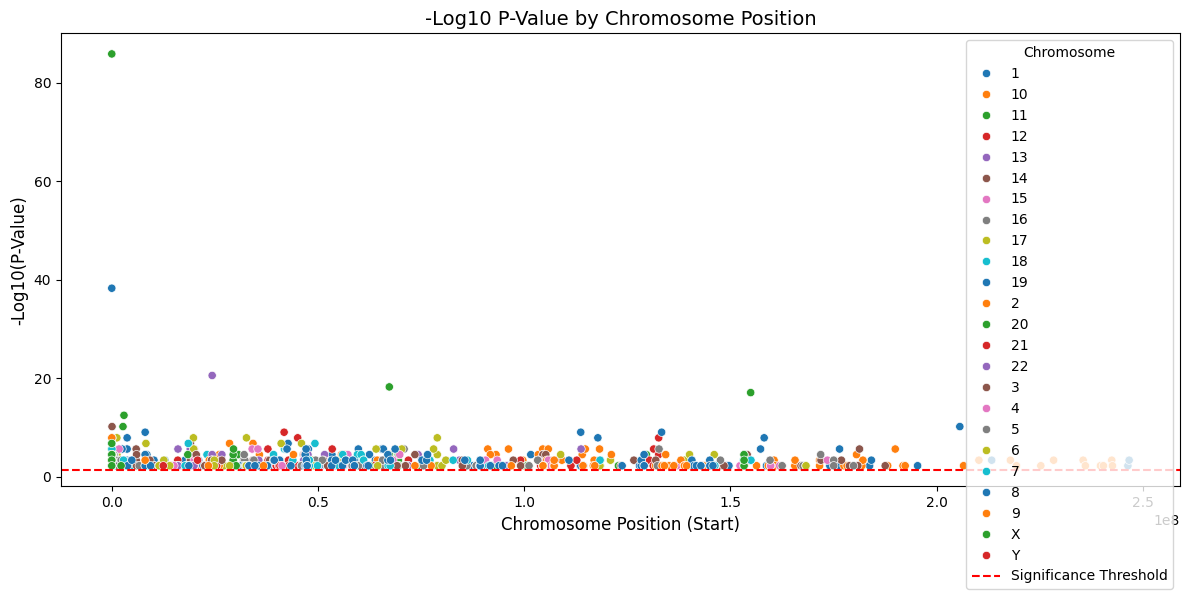

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure chromosome and positions are sorted for better visualization
significant_regions['Chromosome'] = significant_regions['Chromosome'].astype(str)
significant_regions_with_genes = significant_regions.sort_values(by=['Chromosome', 'Start'])

# Bar Plot: Case vs Control Counts
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Chromosome',
    y='Case_Count',
    data=significant_regions_with_genes,
    color='blue',
    label='Case'
)
sns.barplot(
    x='Chromosome',
    y='Control_Count',
    data=significant_regions_with_genes,
    color='orange',
    label='Control'
)
plt.title('Case vs Control Counts by Chromosome', fontsize=14)
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Chromosome', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter Plot: Chromosome Position vs P-Value
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Start',
    y=-np.log10(significant_regions_with_genes['P_Value']),
    hue='Chromosome',
    palette='tab10',
    data=significant_regions_with_genes
)
plt.title('-Log10 P-Value by Chromosome Position', fontsize=14)
plt.xlabel('Chromosome Position (Start)', fontsize=12)
plt.ylabel('-Log10(P-Value)', fontsize=12)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='Significance Threshold')
plt.legend(title='Chromosome')
plt.tight_layout()
plt.show()